# Learn Jax The Way That Makes Sense To Nobody Else

The intention behind this is to get comfortable with Jax up to the point of writing kernels in Pallas. A reasonable showcase of this would be implementation of newer models, the Transformer alternatives, i.e. Based and Griffin.

### Longer Term Goals

- train a model with pallas kernel on a tpu pod or H100. Make sure flops and bandwidth usage is gooood.
- track experiments with wandb

Why not PyTorch?  A few reasons:

- I already know PyTorch well. So this would be kinda boring if I used that.
- Jax has really powerful primitives and is built with a compiler in mind. Talk smack about Google all you want but they ship really incredible ML compiler software: XLA!
- It's used for more than cookie cutter ML. PyTorch is having a moment because 1) Huggingface transformers library, and 2) Transformers are good for everything apparently. But I believe Jax is a better piece of software.
- Deployment. The story here hasn't been great for Jax so far. But honestly, it's not good for PyTorch either, you have a sacrifice a chicken to compile something to mobile. GGML renders all of this obsolete anyway since you can just convert the weight to gguf format and go from there.
- Seems once you know what you're doing scaling it across multiple devices, pods, and clusters is a lot easier.
- Can take advantage of TPUs for training. That's NVIDIA's competition, not AMD. I honestly think this is quite a big flop from Google. Sell these to people FFS! Unless you know, competitive advantage, and yada yada yada :-)

I would like to use Julia for all of this but although SciML has taken off, ~Sci~ML not so much. It's really difficult to compete with MANGA, especially when all the models boil down to a few performant kernels.

In an alternative world, Chris Lattner would have used Julia instead of Swift while at Google, it would have intiated cash flow into the ecosystem from up the tech lords for ML development, and we would live in a utopia. Alas, we don't live there. We live in the world we he's trying to find his Mojo. Paging Dr. Evil.

In [5]:
import jax
from jax.experimental import pallas as pl
import jax.numpy as jnp
import numpy as np
from jax import random

In [6]:
x = jnp.ones((512, 512))

In [7]:
jnp.int4

jax.numpy.int4

In [8]:
# to get a random value we need to use a key
key = random.PRNGKey(452)
y = random.normal(key, (512, 512), jnp.bfloat16)
y

Array([[0.0439453, -0.769531, -1.25781, ..., 0.65625, -2.89062,
        -0.644531],
       [0.304688, 0.241211, -0.292969, ..., -0.71875, 1.54688, 0.427734],
       [-1.73438, 2.01562, 0.839844, ..., -0.746094, -0.71875, 0.283203],
       ...,
       [-2.89062, -0.152344, -0.132812, ..., 0.472656, 0.0245361, -1],
       [0.00488281, -0.0539551, -0.460938, ..., 0.5625, 0.0439453,
        0.894531],
       [-1.03125, 1.38281, 1.625, ..., -0.621094, -0.112305, -1.57812]],      dtype=bfloat16)

In [9]:
z = random.normal(key, (512, 512), jnp.bfloat16)
z

Array([[0.0439453, -0.769531, -1.25781, ..., 0.65625, -2.89062,
        -0.644531],
       [0.304688, 0.241211, -0.292969, ..., -0.71875, 1.54688, 0.427734],
       [-1.73438, 2.01562, 0.839844, ..., -0.746094, -0.71875, 0.283203],
       ...,
       [-2.89062, -0.152344, -0.132812, ..., 0.472656, 0.0245361, -1],
       [0.00488281, -0.0539551, -0.460938, ..., 0.5625, 0.0439453,
        0.894531],
       [-1.03125, 1.38281, 1.625, ..., -0.621094, -0.112305, -1.57812]],      dtype=bfloat16)

In [10]:
jnp.array_equal(y, z)

Array(True, dtype=bool)

That's no good. In JAX we can't reuse a key, we always need to use a new key.

In [11]:
key1, key2 = random.split(key)

In [12]:
key1

Array([1491820686, 1009696691], dtype=uint32)

In [13]:
z = random.normal(key1, (512, 512), jnp.bfloat16)
z

Array([[0.427734, 2.01562, -0.878906, ..., 1.01562, -0.112305, 0.241211],
       [0.5625, -1.25781, 1.78906, ..., 1.28125, -0.271484, 0.585938],
       [-1.10156, 1.04688, -0.3125, ..., 1.24219, -0.132812, 2.51562],
       ...,
       [-1.03125, -0.9375, -0.644531, ..., 0.449219, -0.644531, 0.921875],
       [-0.292969, 0.65625, -0.0146484, ..., 1.24219, 1.24219, 1.125],
       [0.449219, 0.539062, 2.51562, ..., -2.10938, 0.283203, 1.625]],      dtype=bfloat16)

Different values! By the way you can create as many keys as you want.

In [14]:
random.split(key1, num=10)

Array([[2715293149, 1869756952],
       [2143116086, 4269846209],
       [1700306076,  306031570],
       [2972788532, 1569919732],
       [1165125172, 1774103344],
       [4154028601,  514593784],
       [1156115218, 2105534922],
       [2279146592,  105068904],
       [4030971763, 1734275684],
       [2539788112,  255303479]], dtype=uint32)

Ok. I'm wondering why we wouldn't just use random.PRNGKey over and over. Well there are 2 main reasons I can see.

1. PRGNKey creates 1 key, split creates as many as we need.
2. Reproducibility: the randomness of the entire program is initiated by a single seed. We'll get the same values everytime.

In [15]:
jnp.array_equal(random.split(key1, num=10), random.split(key1, num=10))

Array(True, dtype=bool)

We get the same keys!

There's two other ones I need to wrap my head around - vmap and grad.

vmap is a vectorized map. Really it's just a map but the term vectorized is used in array programming. Doing things one element at a time is really, really, really bad in array programming world because it uses hardware in the least effective way.

The alternative to vectorization is a for loop(s). Now for loops aren't actually bad. It's the implementation that's bad. You can make for loops really efficient such that they utilize hardware [incredibly well.](https://github.com/JuliaSIMD/LoopVectorization.jl?tab=readme-ov-file#matrix-multiply).

In fact vectorization, depending on the hardware can really just be a loop, it's just a heavily optimized one. So when someone says "use vectorization" I believe a good way to think about is "use the really optimized for loop routine".

In a language like Python it's particularly bad because it means using a Python for loop instead of a C++ heavily optimized array structure specialiazed for loop.

In any case that's a bit of a tangent because in JAX vmap is semantically much more meaningful. In allows us to not think about batches. Basically we can think of our model as operating on a single example the entire time, slap a vmap on top of that, and everything just works for batches of examples.

Compiler optimizations + DevUX = fire emoji

How does this work?

matmul is an easy enough example.

mk x kn matrices

but mk is bmk because it's batched.

In [16]:
key = random.PRNGKey(0)

weights = random.normal(key, (10, 50))
key1, key2 = random.split(key)
input = random.normal(key1, (20, 10))

f = lambda x: x @ weights
   
z = f(input)
print(z.shape)

(20, 50)


In [17]:
vf = jax.vmap(f, in_axes=0)

X = random.normal(key2, (100, 20, 10))

Z = vf(X)
print(Z.shape)

(100, 20, 50)


Super simplified but it gets across the fundamental use of vmap. Naturally allows us to turn a regular matmul to a batched one.

Batched matmul is perhaps the most common workload in deep learning so naturally JAX supports this out of the box.

In [18]:
(X @ weights).shape

(100, 20, 50)

## grad

this is straightforward, it's just a way to get the gradient. The use case I'm interested in is how to apply this to changing parameters. After all, JAX comes from a functional programming (pure) school of thought.

In [19]:
def f(x):
    return 3 * x**4 + 2 * x**3 + x**2 + 1

def df(x):
    return 12 * x**3 + 6 * x**2 + 2 * x**1

gf = jax.grad(lambda x: jnp.sum(f(x)))
x = jnp.arange(5, dtype=jnp.float32)
print(x)
print(f(x))
print(df(x))
print(gf(x))

[0. 1. 2. 3. 4.]
[  1.   7.  69. 307. 913.]
[  0.  20. 124. 384. 872.]
[  0.  20. 124. 384. 872.]


You can apply grad as much as you want. JAX is different from other frameworks in that it optimizes higher derivatives really well.

In [20]:
from jax import grad

In [21]:
ggf = grad(grad(f))
gggf = grad(ggf)
ggggf = grad(gggf)
gggggf = grad(ggggf)

print(ggf(1.0))
print(gggf(1.0))
print(ggggf(1.0))
print(gggggf(1.))

50.0
84.0
72.0
0.0


eventually we're left with a constant where the gradients is 0

Let's implement linear regression with all we know so far.

Let's say each example is 10 features and we're predicting some value with noise

In [22]:
# Set random seed for reproducibility
key = random.PRNGKey(0)

# Define the number of examples and features
num_examples = 1000
num_features = 10

# Generate random feature values
key, subkey = random.split(key)
X = random.normal(subkey, (num_examples, num_features))

# Generate random coefficients for the linear relationship
key, subkey = random.split(key)
true_coefficients = random.normal(subkey, (num_features,))

# Generate random noise
key, subkey = random.split(key)
noise = random.normal(subkey, (num_examples,)) * 0.2

# Calculate the target values
y = jnp.dot(X, true_coefficients) + noise

In [23]:
key, subkey1, subkey2 = random.split(key, num=3)
W1 = jax.nn.initializers.xavier_normal()(subkey1, (10, 768))
b1 = jnp.zeros(768)
W2 = jax.nn.initializers.xavier_normal()(subkey2, (768, 1))
b2 = jnp.zeros(1)

In [24]:
def model(x, W1, b1, W2, b2):
    # the model is a 2 layer neural net with a gelu activation
    return jax.nn.relu(x @ W1 + b1) @ W2 + b2
    
def loss(x, W1, b1, W2, b2, y):
    return jnp.mean(jnp.square(model(x, W1, b1, W2, b2) - y))

In [25]:
model(X[1, :], W1, b1, W2, b2)

Array([-0.3369435], dtype=float32)

In [26]:
loss(X[1, :], W1, b1, W2, b2, y)

Array(9.395718, dtype=float32)

In [27]:
gloss = grad(loss, argnums=(1,))

In [28]:
ret = gloss(X[1, :], W1, b1, W2, b2, y)
assert len(ret) == 1 # should be only for W1
assert ret[0].shape == (10, 768)

ok let's update the weights now

In [29]:
gloss = jax.value_and_grad(loss, argnums=(1, 2, 3, 4))

@jax.jit
def update(x, y, W1, W2, b1, b2, step_size=5e-4):
    v, grads = gloss(x, W1, b1, W2, b2, y)
    return (v, [grads[0] * step_size, grads[1] * step_size, grads[2] * step_size, grads[3] * step_size])

In [30]:
v, grads = gloss(X[1, :], W1, b1, W2, b2, y)
print(v)
print(len(grads))
for g in grads:
    print(g.shape)

9.395718
4
(10, 768)
(768,)
(768, 1)
(1,)


This might not actually work so let's but it in a single block so we can iterate quicker.

Notes

- using a 2 layer network like this is overkill. We can get the same result with a 1 layer 10 dim one.
- JAX grad updates are tricky, we're better off just using optax. You cannot mutate the current parameters so you need to return the new parameters in the update function. In PyTorch you would just do `+=` but in JAX this does not do what you want. The good news is that JAX optimizes away the extra memory this would normally incur.|

In [32]:
import optax

# Set random seed for reproducibility
key = random.PRNGKey(0)
# Define the number of examples and features
num_examples = 1000
num_features = 10
# Generate random feature values
key, subkey = random.split(key)
X = random.normal(subkey, (num_examples, num_features))
# Generate random coefficients for the linear relationship
key, subkey = random.split(key)
true_coefficients = random.normal(subkey, (num_features,))
# Generate random noise
key, subkey = random.split(key)
noise = random.normal(subkey, (num_examples,)) * 0.2
# Calculate the target values
y = jnp.dot(X, true_coefficients) + noise

key, subkey1, subkey2 = random.split(key, num=3)
W1 = jax.nn.initializers.xavier_normal()(subkey1, (10, 768))
b1 = jnp.zeros(768)
W2 = jax.nn.initializers.xavier_normal()(subkey2, (768, 1))
b2 = jnp.zeros(1)

def model(x, W1, b1, W2, b2):
    # the model is a 3 layer neural net with a relu activation
    h1 = jax.nn.gelu(x @ W1 + b1)
    h2 = h1 @ W2 + b2
    return jnp.squeeze(h2)
    
def loss(x, W1, b1, W2, b2, y):
    return jnp.mean(jnp.square(model(x, W1, b1, W2, b2) - y))

gloss = jax.value_and_grad(loss, argnums=(1, 2, 3, 4))
    
optimizer = optax.adam(learning_rate=6e-3)
opt_state = optimizer.init((W1, b1, W2, b2))

@jax.jit
def update(x, y, params, opt_state):
    (W1, b1, W2, b2) = params
    v, grads = gloss(x, W1, b1, W2, b2, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return v, params, opt_state

num_epochs = 1000
batch_size = 128
for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = X.shape[0] // batch_size
    
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        x_batch = X[batch_start:batch_end]
        y_batch = y[batch_start:batch_end]
        
        l, (W1, b1, W2, b2), opt_state = update(x_batch, y_batch, (W1, b1, W2, b2), opt_state)
        
        epoch_loss += l
    
    epoch_loss /= num_batches
    print(f"Epoch {epoch+1}, Loss = {epoch_loss}")

Epoch 1, Loss = 4.303862571716309
Epoch 2, Loss = 0.6160898208618164
Epoch 3, Loss = 0.3723072409629822
Epoch 4, Loss = 0.18532879650592804
Epoch 5, Loss = 0.12581853568553925
Epoch 6, Loss = 0.07499350607395172
Epoch 7, Loss = 0.05630641430616379
Epoch 8, Loss = 0.049061622470617294
Epoch 9, Loss = 0.04322325438261032
Epoch 10, Loss = 0.04270998015999794
Epoch 11, Loss = 0.040736354887485504
Epoch 12, Loss = 0.03988800570368767
Epoch 13, Loss = 0.03979654237627983
Epoch 14, Loss = 0.03951477259397507
Epoch 15, Loss = 0.03952380642294884
Epoch 16, Loss = 0.039254311472177505
Epoch 17, Loss = 0.03942013904452324
Epoch 18, Loss = 0.039184074848890305
Epoch 19, Loss = 0.03928997740149498
Epoch 20, Loss = 0.039188023656606674
Epoch 21, Loss = 0.03922886773943901
Epoch 22, Loss = 0.03917312249541283
Epoch 23, Loss = 0.03921699523925781
Epoch 24, Loss = 0.03917583078145981
Epoch 25, Loss = 0.03920416906476021
Epoch 26, Loss = 0.03920388221740723
Epoch 27, Loss = 0.03920862823724747
Epoch 28,

Epoch 692, Loss = 0.010891770012676716
Epoch 693, Loss = 0.011140248738229275
Epoch 694, Loss = 0.011400970630347729
Epoch 695, Loss = 0.011724679730832577
Epoch 696, Loss = 0.011916178278625011
Epoch 697, Loss = 0.011878584511578083
Epoch 698, Loss = 0.011827979236841202
Epoch 699, Loss = 0.011935601010918617
Epoch 700, Loss = 0.012223836034536362
Epoch 701, Loss = 0.012838834896683693
Epoch 702, Loss = 0.013875204138457775
Epoch 703, Loss = 0.014913935214281082
Epoch 704, Loss = 0.01540822722017765
Epoch 705, Loss = 0.015217401087284088
Epoch 706, Loss = 0.014728691428899765
Epoch 707, Loss = 0.014609546400606632
Epoch 708, Loss = 0.015118062496185303
Epoch 709, Loss = 0.01588384062051773
Epoch 710, Loss = 0.016250427812337875
Epoch 711, Loss = 0.01571544073522091
Epoch 712, Loss = 0.014692397788167
Epoch 713, Loss = 0.014342703856527805
Epoch 714, Loss = 0.014613546431064606
Epoch 715, Loss = 0.014558227732777596
Epoch 716, Loss = 0.014029902406036854
Epoch 717, Loss = 0.01312336977

Epoch 932, Loss = 0.007214639335870743
Epoch 933, Loss = 0.007885962724685669
Epoch 934, Loss = 0.007142830640077591
Epoch 935, Loss = 0.007650845218449831
Epoch 936, Loss = 0.007643126416951418
Epoch 937, Loss = 0.007981493137776852
Epoch 938, Loss = 0.007540537044405937
Epoch 939, Loss = 0.007803563494235277
Epoch 940, Loss = 0.00831476878374815
Epoch 941, Loss = 0.007777410093694925
Epoch 942, Loss = 0.00825024489313364
Epoch 943, Loss = 0.007827944122254848
Epoch 944, Loss = 0.008837807923555374
Epoch 945, Loss = 0.007697024382650852
Epoch 946, Loss = 0.008631201460957527
Epoch 947, Loss = 0.00812570471316576
Epoch 948, Loss = 0.008543359115719795
Epoch 949, Loss = 0.008352862671017647
Epoch 950, Loss = 0.00810808502137661
Epoch 951, Loss = 0.008793339133262634
Epoch 952, Loss = 0.008053544908761978
Epoch 953, Loss = 0.008824418298900127
Epoch 954, Loss = 0.008105548098683357
Epoch 955, Loss = 0.008967215195298195
Epoch 956, Loss = 0.008826855570077896
Epoch 957, Loss = 0.008766939

what else should we cover for preliminary purposes? maybe pmap? That's a multi device thing so perhaps not yet.

going forward we'll use flax for composing models together since we're trying to reinvent the wheel here. It simplifies a lot of this process.

for data loading tfds is typically used but I really don't want to deal with TensorFlow. Huggingface datasets is really easy to use, so let's try to use that.

In [33]:
from flax import linen as nn

I'm going to disgress a bit here and go into attention implementations. Attention is the core building block of Transformer model and likely all token based models going forward unless something changes drastically. And more and more models are becoming token based models.

Attention is, simply, in simplistic layman's terms, the matter of determining which generated tokens are important for prediction of the next token.

What this looks like in practice is a heatmap of a lower triangular matrix

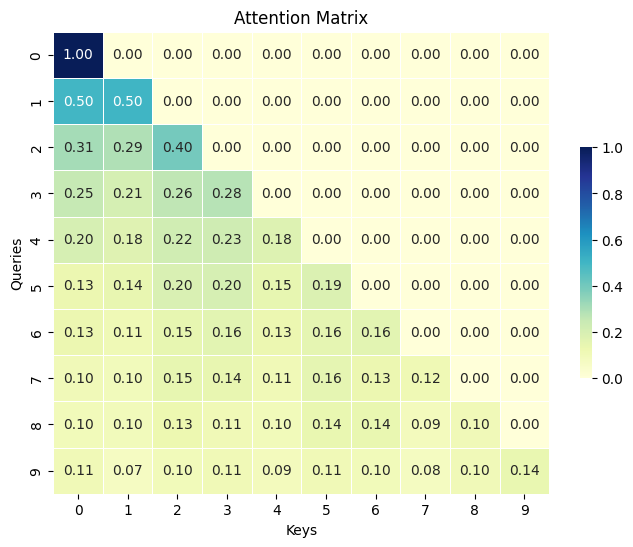

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

seq_len = 10
head_dim = 32
Q = np.random.rand(seq_len, head_dim)
K = np.random.rand(seq_len, head_dim)
mask = jnp.tril(jnp.ones((seq_len, seq_len)))
attn = jax.nn.softmax((Q @ K.T) / jnp.sqrt(head_dim), where=mask, initial=0)

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(attn, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Set title and labels
plt.title("Attention Matrix")
plt.xlabel("Keys")
plt.ylabel("Queries")

# Show the plot
plt.show()

The simplest attention kernel is softmax(Q*K^T / sqrt(d)) * V 

In [43]:
def casual_attention(x, Q, K, V, mask):
    """
    x is the input tensor of shape (seq_len, dim)
    Q, K, V are the weight matrices of shape (dim, dim)
    O is the output weight matrix of shape (dim, dim)
    mask is the mask tensor of shape (seq_len, seq_len)
    """
    q = x @ Q
    k = x @ K
    v = x @ V
    dim = jnp.array(x.shape[-1], dtype=jnp.float32)
    logits = jax.nn.softmax(((q @ k.T) / jnp.sqrt(dim)), where=mask, initial=0)
    return logits @ v, logits

key = jax.random.PRNGKey(0)
seq_len = 4
dim = 10
x = jax.random.normal(key, (seq_len, dim))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (dim, dim))
K = jax.random.normal(key2, (dim, dim))
V = jax.random.normal(key3, (dim, dim))
mask = jnp.tril(jnp.ones((seq_len, seq_len)))

output, attn = casual_attention(x, Q, K, V, mask)
print(output.shape)
print(attn.shape)



(4, 10)
(4, 4)


This is closer to an implementation of what you would actually find in the wild. What I really want you to pay attention to, pun intended, in the shape of q, k, and v.

it is (b, h, s, hd).

What does this mean?

We are using attention for every (b, h) pair. Assume b = 1. Each head has its own attention matrix. This is why it's called multi-head attention. Now, potentially each head learns something different.

In [44]:
def batched_casual_attention(x, Q, K, V, mask):
    """
    x is the input tensor of shape (b, s, d)
    Q, K, V are the weight matrices of shape (d, d)
    mask is the mask tensor of shape (b, h, s, s)
    the output is of shape(b, s, d)

    b is the batch size
    s is the sequence length
    d is the embedding dimension
    h is the number of heads

    each head gets its own attention matrix.
    """
    b,s,d = x.shape
    h = mask.shape[1]
    hd = d // h
    q = (x @ Q).reshape(b, h, s, hd)
    k = (x @ K).reshape(b, h, s, hd)
    v = (x @ V).reshape(b, h, s, hd)
    attn_m = jnp.einsum('bhqd, bhkd -> bhqk', q, k) / jnp.sqrt(hd)
    logits = jax.nn.softmax(attn_m, where=mask, initial=0)
    o = jnp.einsum('bhqk, bhvd -> bhqd', logits, v)
    ret =  jnp.einsum('bhqd->bqhd', o).reshape(b, s, d)
    return ret, logits


key = jax.random.PRNGKey(0)
bs = 2
sq = 4
dim = 32
heads = 8
x = jax.random.normal(key, (bs, sq, dim))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (dim, dim))
K = jax.random.normal(key2, (dim, dim))
V = jax.random.normal(key3, (dim, dim))
mask = jnp.tril(jnp.ones((bs, heads, sq, sq)))

output, attn = batched_casual_attention(x, Q, K, V, mask)
print(output.shape)
print(attn.shape)

(2, 4, 32)
(2, 8, 4, 4)


Transformer models seem to be universally good base models. I believe this is because of two factors:

1. attention block
2. resnet passthrough mechanism

allow me explain 2) further. Prior to resnet, or perhaps u-net? Did u-net come out before resnet? anyway, resnet opularized it because they achieved state of the art performance on ImageNet. Yes, back when classfying 1000 classes was what all the cool kids were trying to do.

Resnet introduced this passthrough mechanism whereby one kept the output the previous layers by adding it, basically if you had a layer f, which takes input x, then the output if not just f(x), but f(x) + x. This subtle change allows backpropagation to alter x in a more direct manner, shown directly by the sheer numbers of layers resnet could use without gradient issues, yes gradient issues, those were also a thing. Vanishing gradients, exploding gradients, really those gradients were could a handful, nothing like the well behaved ones we see today.

Transformers keep this mechanism, but also add the attention block, which allows the network to learn how one part of the input affects all the others.

Interestingly, Transformer models we find now are simpler than the original, but these two components stay.

Now that we've come across this universal architecture, now we optimize it for actual use.

> a single layer neural network is a universal function approximator, if it is wide enough, but getting that to actually work in practice have panned out to well. Perhaps this is partly a hardware issue, since you can only fit so much into GPU memory, for the time being more, narrow layers are favoured over fewer, wider ones.

### Training

Use the GPU as much as possible. The speed at which a GPU can compute is >> than the speed at which it can load/read it into memory. Thus most of the work here is enabling that, and doing that at a massive scale. Over many accelerators.

### Inference

Inference is in many ways much more interesting, the input is far less constrained, and also this is the direct use case. If it can't infer quickly, then it's useless, nobody will want to use it. Much more the work for faster kernels directly transfer over to here as well. But there are also several inference optimizations we can make as well.



### Multi-Query Attention

https://arxiv.org/pdf/1911.02150.pdf

This paper introduces mutli-query attention, a variation of multi-head attention.

Ok, here's my problem. I see many articles about this online, but none of them explain why I should give a shit about MQA. This is problem with explanations in general, they came from the assumption you know why it's important. Maybe they don't even know why it's important. I just realized this is why Karpathy is such an excellent teacher. He explains why it's important, why _this_, and not _that_.

Ok.

So why is this important.

It comes down to this observation. An accelerator, like a GPU can do arithmetic operations orders of magnitude faster than it can process (read/write) data to memory. This means we want to constantly feed it data, such that there is gap where it is so fully utilizing the available compute.

In the context of training this is generally not a problem, since we give the accelerator the largest batch size it can fit.

- b - batch size
- s - sequence length
- d - embedding dimension
- h - numbers of heads
- dh - head dimension = d / h

If we have two matrices A (s * d), and B (d * s), then the work for matrix multiplication is $O(s^2*d)$

Arithmetic operators are $O(b * h * s^2 * dh) = O(b * d * s^2)$ + $O(b * s * d^2)$. Depending on whether $d$ or $s$ is larger, one of these is the dominant factor.

For inference, d >= s, is likely.

The paper just threw $O(b * s * d^2)$ out there, and it confused me, because the limiting factor you hear about transformers is sequence length. It's the inference assumption we make, and quite frankly, perhaps at the time of this paper context length of 128k, 200k, or 1M wasn't thought of so much. Most of the tasks still dealt with classification or the like. In 2019 generative models weren't used in the way they are now. So if the inference sequence length is in the hundreds or even less, then it's safe to assume the math they use.

Size of memory is $O(bsd + bhs^2 + d^2)$.

$$
bsd / bsd^2 = 1 / d \\
bhs^2 / bsd^2 = s / d^2 = s / (dh*h)^2 \\
d^2 / bsd^2 = 1 / bs \\
$$

We assume that d >= s and so $s / d^2 <= d / d^2 = 1 / d$ which leaves us with $O(1/d + 1/(b*s))$

So this means ratio of memory access to arithmetic operations is low, arithmetic operations > memory accesses. This is good, we want workloads where this is the case.

I'll be honest. At first glance I don't see why this is important, since we need to access data in memory to do the computation. But I think this is important, particularly in the case of an accelerator because the size of the _fast_ memory is very small. From a CPU perspective we have, in order of speed from slowest to fastest: RAM, cache (L3, L2, L1), ALU registers. It's similar for GPUs/TPUs. So, I guess, the more we can keep the current workload in the fastest memory without swapping it the better.

Anyway this ratio is the whole idea behind MQA. In the setting where we compute MHA one step at a time, i.e. inference.

For memory access:

$O(bsd + bhs^2 + d^2)$ done 1 up to s times  is $O(bs^2d + bhs^3 + sd^2)$ since (1 + 2 + 3 ... + s-1 + s) is $O(s^2)$.

bhs^3 is derived from logits and weights, but now our input is no longer (b, s, d) but (b, d), since it's one step.

the step to get logits is (Q * K^T), now (q * K^T). In the scenario with one head this is (1, d) x (d, s) = (1, s). Adding the batch and head dimensions it's now (b, h, s), where as before this would have been (b, h, s, s).

And so this is not bhs^3 but the same as bhs^2.

For arithmetic operations:

$O(b * d * s^2) + O(b * s * d^2)$

the first term is the attention part, the second term is matmuls for the projections.

now since the input is one step the second term actually be $O(b*d^2)$, but it's done over s calls, so we're back to $O(b*s*d^2)$.

Again, we remove a factor of s for the first term because the attention computation is (1, d) x (d, s) and not (s, d) x (d, s), over s calls that's back to $O(b * d * s^2)$. And we're left with the exact same result. If we weren't keeping track of the previous K, V computations then this would increase by a factor of $s$.

Let's do the ratio again:

$$
bs^2d / bsd^2 = s / d
bhs^2 / bsd^2 = s / d^2 \\
sd^2 / bsd^2 = 1 / b \\
$$

$O(s/d + s/d^2 + 1/b)$

Following the same logic as before we are left with $O(s/d + 1/b)$ which is the result of the paper.

when b ~= 1 or s ~=d the ratio is close to 1, which is really, really bad. This means memory bandwidth is the limiting factor in the computation. b is limited only by memory capacity. Otherwise we want d > s. As the sequence length increase there's not much we can do. d is a constant, the dimension of a linear layer of the network. It is determined before we start training. And so we're only left with manipulating $s$ somehow...

We need to make $s/d$ something else. This term is derived K and V. We have to load (b, h, s, dh) elements into memory, when s ~= d, (b, s, s) elements. The only thing we can possibly reduce here is h. If h is 1 then this is (b, s, dh) elements. 

The original term is $bs^2d$ but if d ~= s then it's $bs^3$. Ok. Now we had it $bs^2*dh$ instead.

$ (bs^2*dh) / bs^3 = dh / s $

since $bsd^2 = bs^3$

So now we have $ dh / s $ when s ~= d. Which reduces the cost by a factor h.

The derivation in the paper is a bit different. I'm not sure exactly how they come up with it but the factor of h is consistent either way.

Anyway the entire point of this is for the ratio of memory accesses vs. arithmetic operations to be low. During inference we can encounter situations where memory bandwidth becomes a limiting factor for throughput, so it should be minimized.

In [45]:
def mqa(x, Q, K, V, mask):
    """
    x is the input tensor of shape (b, s, d)
    Q are the weight matrices of shape (d, d)
    K, V are the weight matrices of shape (d, k) where k = d // h
    mask is the mask tensor of shape (b, h, s, s)
    the output is of shape(b, s, d)

    b is the batch size
    s is the sequence length
    d is the embedding dimension
    h is the number of heads

    each head gets its own attention matrix.
    """
    b,s,d = x.shape
    h = mask.shape[1]
    hd = d // h
    q = (x @ Q).reshape(b, h, s, hd)
    k = (x @ K).reshape(b, s, hd)
    v = (x @ V).reshape(b, s, hd)
    attn_m = jnp.einsum('bhqd, bkd -> bhqk', q, k) / jnp.sqrt(hd)
    logits = jax.nn.softmax(attn_m, where=mask, initial=0)
    o = jnp.einsum('bhqk, bvd -> bhqd', logits, v)
    ret =  jnp.einsum('bhqd->bqhd', o).reshape(b, s, d)
    return ret, logits

In [46]:
key = jax.random.PRNGKey(0)
b = 2
s = 4
d = 32
h = 8
x = jax.random.normal(key, (b, s, d))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (d, d))
K = jax.random.normal(key2, (d, d // h))
V = jax.random.normal(key3, (d, d // h))
mask = jnp.tril(jnp.ones((b, h, s, s)))

output, attn = mqa(x, Q, K, V, mask)
print(output.shape)
print(attn.shape)

(2, 4, 32)
(2, 8, 4, 4)


with an incremental cache

In [56]:
@jax.jit
def mqa_incremental_cache(x, Q, K, V, K_cache=None, V_cache=None):
    """
    x is the input tensor of shape (b, d)
    Q are the weight matrices of shape (d, d)
    K, V are the weight matrices of shape (d, k) where k = d // h
    mask is the mask tensor of shape (b, h, s, s)
    K_cache, V_cache is of shape (b, s, k)
    
    the output is of shape(b, s, d)

    b is the batch size
    s is the sequence length
    d is the embedding dimension
    h is the number of heads

    each head gets its own attention matrix.
    
    Omitting the output matrix O just to simplify things.
    """
    b,d = x.shape
    hd = d  // h
    q = (x @ Q).reshape(b, h, hd)
    k = (x @ K)
    v = (x @ V)
    
    if K_cache is not None:
        K_cache = jnp.concat((K_cache, jnp.expand_dims(k, axis=1)), axis=1)
    else:
        K_cache = jnp.expand_dims(k, axis=1)
        
    if V_cache is not None:
        V_cache = jnp.concat((V_cache, jnp.expand_dims(v, axis=1)), axis=1)
    else:
        V_cache = jnp.expand_dims(v, axis=1)
            
    attn_m = jnp.einsum('bhk,bsk->bhs', q, K_cache) / jnp.sqrt(hd)
    logits = jax.nn.softmax(attn_m)
    o = jnp.einsum('bhs,bsk->bhk', logits, V_cache).reshape(b, d)
    return o, K_cache, V_cache

In [59]:
key = jax.random.PRNGKey(0)
b = 4
s = 10
d = 128
h = 8
x = jax.random.normal(key, (b, d))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (d, d))
K = jax.random.normal(key2, (d, d // h))
V = jax.random.normal(key3, (d, d // h))

K_cache = None
V_cache = None

for step in range(s):
    x, K_cache, V_cache = mqa_incremental_cache(x, Q, K, V, K_cache, V_cache)
    print(f'caches step {step}: {K_cache.shape}')

print(x.shape)

caches step 0: (4, 1, 16)
caches step 1: (4, 2, 16)
caches step 2: (4, 3, 16)
caches step 3: (4, 4, 16)
caches step 4: (4, 5, 16)
caches step 5: (4, 6, 16)
caches step 6: (4, 7, 16)
caches step 7: (4, 8, 16)
caches step 8: (4, 9, 16)
caches step 9: (4, 10, 16)
(4, 128)


This isn't jit friendly since K_cache and V_cache change shapes. In Jax mutations aren't as simple as PyTorch but there are low level APIs for this kind of thing: jax.lax.dynamic_update_slice_in_dim

In [80]:
@jax.jit
def mqa_incremental_cache(step, x, Q, K, V, K_cache, V_cache):
    """
    x is the input tensor of shape (b, d)
    Q are the weight matrices of shape (d, d)
    K, V are the weight matrices of shape (d, k) where k = d // h
    mask is the mask tensor of shape (b, h, s, s)
    K_cache, V_cache is of shape (b, s, k)
    
    the output is of shape(b, s, d)

    b is the batch size
    s is the sequence length
    d is the embedding dimension
    h is the number of heads

    each head gets its own attention matrix.
    
    Omitting the output matrix O just to simplify things.
    """
    b,d = x.shape
    hd = d  // h
    q = (x @ Q).reshape(b, h, hd)
    k = (x @ K)
    v = (x @ V)
      
    K_cache = jax.lax.dynamic_update_slice_in_dim(K_cache, jnp.expand_dims(k, axis=1), step, axis=1)
    V_cache = jax.lax.dynamic_update_slice_in_dim(V_cache, jnp.expand_dims(v, axis=1), step, axis=1)

    # I think we can just do K_cache here since 0s function as same as just using the step
    attn_m = jnp.einsum('bhk,bsk->bhs', q, K_cache) / jnp.sqrt(hd)
    logits = jax.nn.softmax(attn_m)
    o = jnp.einsum('bhs,bsk->bhk', logits, V_cache).reshape(b, d)
    return o, K_cache, V_cache

In [84]:
key = jax.random.PRNGKey(0)
b = 4
s = 10
d = 128
h = 8
x = jax.random.normal(key, (b, d))

key1, key2, key3 = jax.random.split(key, num=3)

Q = jax.random.normal(key1, (d, d))
K = jax.random.normal(key2, (d, d // h))
V = jax.random.normal(key3, (d, d // h))

K_cache = jnp.zeros((b, s, d // h))
V_cache = jnp.zeros((b, s, d // h))

for step in range(s*4):
    step % s
    x, K_cache, V_cache = mqa_incremental_cache(step, x, Q, K, V, K_cache, V_cache)
    print(f'caches step {step}: {K_cache.shape}')

print(x.shape)

caches step 0: (4, 10, 16)
caches step 1: (4, 10, 16)
caches step 2: (4, 10, 16)
caches step 3: (4, 10, 16)
caches step 4: (4, 10, 16)
caches step 5: (4, 10, 16)
caches step 6: (4, 10, 16)
caches step 7: (4, 10, 16)
caches step 8: (4, 10, 16)
caches step 9: (4, 10, 16)
caches step 10: (4, 10, 16)
caches step 11: (4, 10, 16)
caches step 12: (4, 10, 16)
caches step 13: (4, 10, 16)
caches step 14: (4, 10, 16)
caches step 15: (4, 10, 16)
caches step 16: (4, 10, 16)
caches step 17: (4, 10, 16)
caches step 18: (4, 10, 16)
caches step 19: (4, 10, 16)
caches step 20: (4, 10, 16)
caches step 21: (4, 10, 16)
caches step 22: (4, 10, 16)
caches step 23: (4, 10, 16)
caches step 24: (4, 10, 16)
caches step 25: (4, 10, 16)
caches step 26: (4, 10, 16)
caches step 27: (4, 10, 16)
caches step 28: (4, 10, 16)
caches step 29: (4, 10, 16)
caches step 30: (4, 10, 16)
caches step 31: (4, 10, 16)
caches step 32: (4, 10, 16)
caches step 33: (4, 10, 16)
caches step 34: (4, 10, 16)
caches step 35: (4, 10, 16)
ca

Now the jit works perfectly. The Jax compiler provides pretty decent error messages. For example, when I was using typical indexing syntax X[:, 2, :], it threw and error and told me why: the index cannot be dynamic and the value of step changes on each iteration. Any form of dynamism must be explicitly known to the compiler such that it can attempt to optimize it.

I also wondered why Jax doesn't automatically convert high-level syntax to the lower-level ops in the case of get/set indexing. I think it's because it cannot reason performance wise about arbitrary indexing, only a limited subset.

The other cool thing is that we've implemented the KV cache used for sliding window attention.

## Sliding Window Attention


Well not quite. We need a rolling buffer. I can't find a good implement of this. A rolling buffer is simple enough, when the cache gets to its maximum capacity we begin by evicting the least recently added element and so on. So if the max size is 3 and we have (1,2,3), if we get 4, now it's (2,3,4).

On paper it's simple enough but let's think about the actual implementation. We work with static tensors. If we do this naively it means we are moving s-1 elements, where the element is a matrix when a new element is added. What was at index 1 is now at index 0, etc.

So what can we do? We could do just that. It might turn out it's not an issue. The data is already there on chip, so it's not like were moving it far.

An other solution is to evict more than 1 element. At least that way we reduce the frequency at which all elements need to be shifted. If the sliding window size is 1000 perhaps throwing out the first 10, or 50 tokens is worthwhile. This small change is a 10x, 50x or more reduction in the number of times we shift.

I wasn't able to find a reference implementation that does something different. They all seem to just do some kind of swapping strategy. Storing the values in FP8 or lower is also a strategy. You need to convert back to bf16 for any calculations.

It's O(smn) to swap the entire cache, which is pretty much a matmul.

There are fancy things we could do. Maybe evict k tokens, where k based on GPU tensor core properties, and then load memory from the cache a certain way. More concretely, a regular matmul implementation is something like matmul(aptr, bptr, cptr) where the pointers point to the start of the matrix (0,0). But we can make it point to any arbitrary section of the matrix. At the lowest level tensor cores operate on 16x16 matrices. So the idea is to evict k elements such that we can efficiently load and store the memory. One token evict wouldn't work because it would cross into the other tokens, so it would be wasteful since we would need to apply a mask or something. Anyway, I think something like this could work.

I think the mistral implementation actually does something with RoPE so that the ordering in the KV cache doesn't actually matter. But it still looks like they do an O(smn) read and write each token generated.

In [122]:
        # # The cache is a rotating buffer
        # scatter_pos = (positions[-self.sliding_window:] % self.sliding_window)[None, :, None, None]
        # scatter_pos = scatter_pos.repeat(bsz, 1, self.n_kv_heads, self.args.head_dim)
        # self.cache_k[:bsz].scatter_(dim=1, index=scatter_pos, src=xk[:, -self.sliding_window:])
        # self.cache_v[:bsz].scatter_(dim=1, index=scatter_pos, src=xv[:, -self.sliding_window:])

import torch

pos = torch.arange(0, 5)
sw = 32
print(pos[-sw:])
spos = (pos[-sw:] % sw)[None, :, None, None]
spos = spos.repeat(2, 1, 4, 16)
print(spos)

tensor([0, 1, 2, 3, 4])
tensor([[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

         [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],

         [[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
          [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]],

         [[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
          [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]],

        

Mistral 7B model has 32 layers, 32 query heads, a hidden size of 4096, and a head dimension of 128.

In [128]:
batch_size = 1
storage_bytes = 1
sliding_window_length = 4096
kv_heads = 8

In [129]:
(batch_size * 32 * kv_heads * 128 * 2 * storage_bytes * sliding_window_length) / (1024**2) # MB

256.0

If we use FP8 as a storage format we can fit the KV cache in 256MB of memory. Even a 32K context is only 2GB, that's not bad. If we have 32 layers then we have a theoretical context window of 1M.

It's not intuitive why this is the case.

Suppose we have 8 positions and a sliding window of 3

(1,2,3,4,5,6,7,8)

at position 5 we attend to position 3, 4, and 5. That information signal is passed to the next layer. So in the next layer position 5 has information about position 3,4, and 5 from the previous layer. Likewise, in the second layer, from the 5th position we attend to position 3, 4, and 5, just like the first layer. But this time, in the second layer each position compresses information about the first layer:

5 - (5, 4, 3)
4 - (4, 3, 2)
3 - (3, 2, 1)

We so can see in the second layer position 5 has information about all the previous positions:

theoretical_context_length = sliding_window * num_layers

This is another reason why the KV cache is important and useful in training as well as inference. With the cache we are not only saving work but also keep information about previous context no longer in the cache.

The memory aspect of the cache only applies to later layers. For the first few layers it's not as useful but suppose you are at the 30th layer in and you're currently in the window (92k, 100k). The first token in the cache (92k token) has information about the last

30 * 8000 = 240,000 tokens.

I don't think this theoretical value is actually used in practice. Mistral has a 4k sliding window and 32 layers so technically a 132k context window, yet it advertises a 32k context window, ~4x smaller.